### Step 1: Importing necessary modules and packages

In [10]:
import os  # Module for interacting with the operating system
import openmc  # OpenMC module for Monte Carlo particle transport simulation
import paramak  # Paramak module for CAD-based fusion reactor design
import CAD_to_OpenMC.assembly as cad_conv  # Custom module for CAD to OpenMC conversion
import plotly.graph_objects as go  # Module for interactive graphing
import matplotlib.pyplot as plt  # Module for plotting graphs
import matplotlib.image as mpimg  # Module for handling images
import numpy as np  # Module for numerical operations

#### Note: Clear old simulation files using Reset before running a new simulation

### Step 2: Defining Materials

In [11]:
# Define stainless steel material
stainless_steel = openmc.Material(name='stainless_steel') 
stainless_steel.set_density('g/cm3', 8.0)
stainless_steel.add_element('Fe', 0.74)  # 74% Iron
stainless_steel.add_element('Cr', 0.18)  # 18% Chromium
stainless_steel.add_element('Ni', 0.08)  # 8% Nickel

# Define high-density polyethylene (HDPE) material
hdpe = openmc.Material(name='HDPE')
hdpe.add_element('H', 0.143711)  # Hydrogen
hdpe.add_element('C', 0.856289)  # Carbon
hdpe.set_density('g/cm3', 0.953)

# Export materials to XML for use in OpenMC simulation
materials = openmc.Materials([stainless_steel, hdpe])
materials.export_to_xml()

### Step 3: Defining Source

In [15]:
# Define spherical detector region
outer_source_sphere = openmc.Sphere(r=10.0)
inner_source_sphere = openmc.Sphere(r=9.5, boundary_type='vacuum')
source_region = +inner_source_sphere & -outer_source_sphere

# Detector (stainless steel shell)
outer_detector_sphere = openmc.Sphere(r=200.0, boundary_type='vacuum')
detector_region = +outer_source_sphere & -outer_detector_sphere
detector_cell = openmc.Cell(name='Detector', fill=hdpe, region=detector_region) 

# Define vacuum inside the source region
vacuum_cell = openmc.Cell(name='Vacuum', fill=None, region=source_region)

# Root Universe to hold the geometry
root_universe = openmc.Universe(cells=[vacuum_cell, detector_cell])
geometry = openmc.Geometry(root_universe)
geometry.export_to_xml()

source = openmc.IndependentSource()
source.space = openmc.stats.Box(
    [-9.5, -9.5, -9.5], [9.5, 9.5, 9.5], only_fissionable=False
)
source.angle = openmc.stats.Isotropic()
source.energy = openmc.stats.Discrete([2.45e6], [1.0])  # 2.45 MeV in eV

### Step 4: Defining Detector

In [16]:
outer_detector_sphere = openmc.Sphere(r=20.0, boundary_type='vacuum')
detector_region = +outer_source_sphere & -outer_detector_sphere
detector_cell = openmc.Cell(name='Detector', fill=hdpe, region=detector_region)

# Vacuum inside the source
vacuum_cell = openmc.Cell(name='Vacuum', fill=None, region=source_region)

# Root Universe
root_universe = openmc.Universe(cells=[vacuum_cell, detector_cell])
geometry = openmc.Geometry(root_universe)
geometry.export_to_xml()

### Step 5: Defining Simulation Settings

In [17]:
settings = openmc.Settings()
settings.source = source  # Assign the defined source
settings.run_mode = 'fixed source'  # Fixed source simulation mode
settings.batches = 200  # Number of batches
settings.inactive = 10  # Number of inactive batches
settings.particles = 100000  # Number of particles per batch

# Track source information
settings.track = [(1, 1, 1)]  # Track the first particle in the first generation of the first batch
settings.sourcepoint_write = True  # Write source points to statepoint file

# Collect and export settings
settings.export_to_xml()

### Step 6: Defining Tally

In [18]:
# Define energy bins for tally
energy_bins = np.linspace(0.1, 20.1, num=101)  # Energy bins from 0.1 MeV to 20.1 MeV
energy_bins_eV = energy_bins * 1e6  # Convert energy bins to eV

# Define filters for tally
cell_filter = openmc.CellFilter(detector_cell)  # Filter for the detector cell
energy_filter = openmc.EnergyFilter(energy_bins_eV)  # Filter for energy bins

# Define the energy deposition tally
energy_deposition_tally = openmc.Tally(name='energy_deposition_tally')
energy_deposition_tally.filters = [cell_filter, energy_filter]
energy_deposition_tally.scores = ['heating']  # Tally the heating (energy deposition)

# Export tallies to XML
tallies = openmc.Tallies([energy_deposition_tally])
tallies.export_to_xml()

### Step 7: Run Simulation

In [19]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

### Step 8: Analyzing Results

In [20]:
# Load the results
sp = openmc.StatePoint('statepoint.200.h5')

# Access the tally results
tally = sp.get_tally(name='energy_deposition_tally')

# Extract the energy deposition data
df = tally.get_pandas_dataframe()

# Process the results to get the format needed
# Group by energy bins and sum the counts
energy_deposition = df.groupby('energy low [eV]').sum().reset_index()

# Convert energy bins from eV to MeV
energy_deposition['energy low [MeV]'] = energy_deposition['energy low [eV]'] * 1e-6

# Round ONLY the 'mean' column (Counts) to integers
energy_deposition['mean'] = energy_deposition['mean'].astype(int)

# Prepare the final results in the desired format
results = energy_deposition[['energy low [MeV]', 'mean']].copy()
results.columns = ['Energy (MeV)', 'Counts']

# Print the results
print(results.to_string(index=False))

 Energy (MeV)  Counts
          0.1    6780
          0.3    8173
          0.5    9330
          0.7   10875
          0.9   13356
          1.1   16898
          1.3   24066
          1.5   27517
          1.7   60021
          1.9   43387
          2.1   39805
          2.3  344539
          2.5       0
          2.7       0
          2.9       0
          3.1       0
          3.3       0
          3.5       0
          3.7       0
          3.9       0
          4.1       0
          4.3       0
          4.5       0
          4.7       0
          4.9       0
          5.1       0
          5.3       0
          5.5       0
          5.7       0
          5.9       0
          6.1       0
          6.3       0
          6.5       0
          6.7       0
          6.9       0
          7.1       0
          7.3       0
          7.5       0
          7.7       0
          7.9       0
          8.1       0
          8.3       0
          8.5       0
          8.7       0
          

### Step 9: Visualizing Results

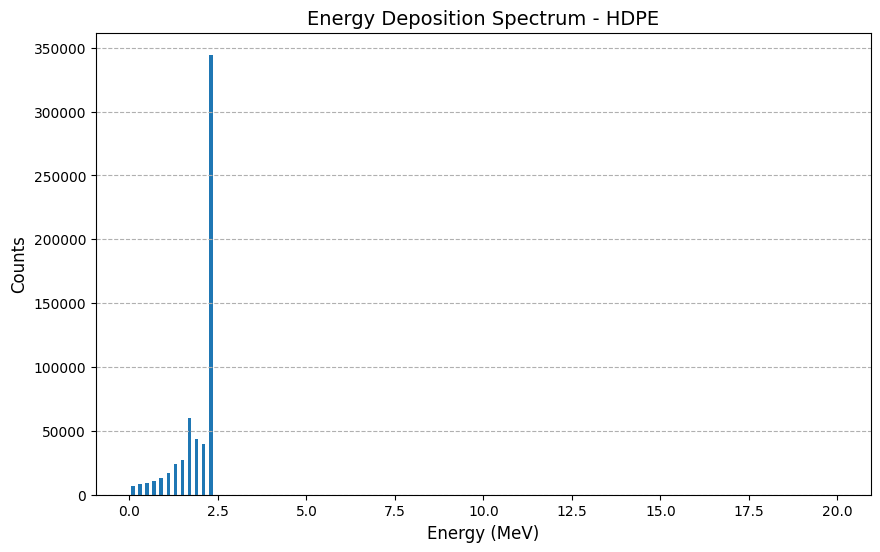

In [21]:
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(results['Energy (MeV)'], results['Counts'], width=0.1)  # Adjust width for bar thickness
plt.xlabel('Energy (MeV)', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Energy Deposition Spectrum - HDPE', fontsize=14)
plt.grid(axis='y', linestyle='--')
plt.show()

### Step 10: Exporting results

In [28]:
results.to_csv('energy_deposition_hdpe.csv', index=False)

# Print success message
print("Results exported to energy_deposition.csv")

Results exported to energy_deposition.csv
